In [1]:
from src.thickness_dataset import ThicknessDataset, ToTensor
from src.models import U_Net
from src.trainer import Trainer

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
import pandas as pd

import albumentations as A
from albumentations.pytorch import ToTensorV2

PATH = "data\gen_data_6000_v2"

In [2]:
thickness_dataset = ThicknessDataset(PATH)

# Calculate mean and std
image_loader = DataLoader(thickness_dataset, 
                          batch_size  = 128, 
                          shuffle     = False, 
                          num_workers = 4,
                          pin_memory  = True)


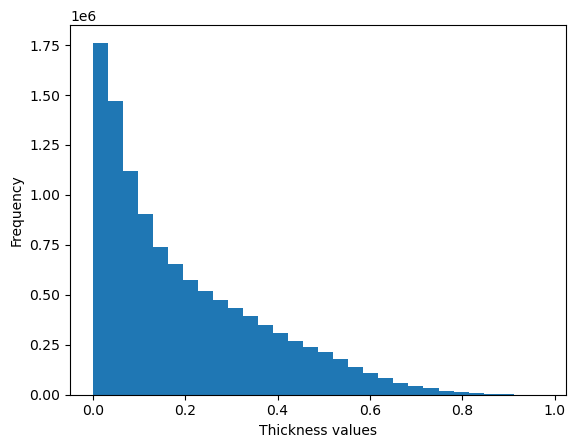

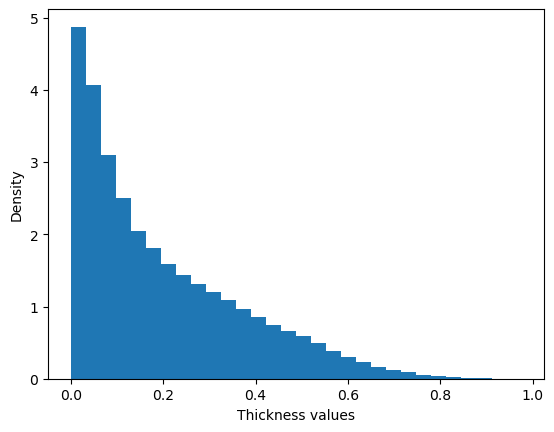

In [3]:
thick_maps = []

for batch in image_loader:
    thick_map = batch['thick_map']
    # Ignore zero values in the depth map
    thick_map = thick_map[thick_map!=0]
    
    thick_maps.append(thick_map)
thick_maps = torch.cat(thick_maps, dim=0).numpy()

plt.hist(thick_maps.flatten(), bins=30)
plt.xlabel('Thickness values')
plt.ylabel('Frequency')
plt.show()

plt.hist(thick_maps.flatten(), bins=30, density=True)
plt.xlabel('Thickness values')
plt.ylabel('Density')
plt.show()

In [4]:
# Physical constraints: The object or material being imaged may have physical constraints that limit the minimum and maximum possible thickness values. For example, if the material cannot be thinner than a certain thickness, there may be a higher density of thickness values closer to zero. resoning for this 

In [5]:
from torch.utils.data.sampler import Sampler
class MyBatchSampler(Sampler):
    def __init__(self, batches):
        self.batches = batches

    def __iter__(self):
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

In [6]:
# calculate an average of the thickness value for each catagory and plot it USING THE DATALOADER
avg_thick = {}
thick_list = {}
stds_list = {}
count_list = {}
index_list = thickness_dataset.dataframe.groupby('catagory_id').apply(lambda x: x.index.tolist())

dataloader = DataLoader(thickness_dataset, batch_sampler=MyBatchSampler(index_list))

for batch in dataloader:
    # print(batch)
    thick_map = batch['thick_map']
    id = batch['catagory_id'][0]
    thick_list[id] = torch.mean(thick_map, dim=0)[0]
    thick_map = thick_map[thick_map!=0]
    avg = thick_map.mean().item()
    avg_thick[id] = avg
    std = thick_map.std().item()
    stds_list[id] = std
    count = len(batch["catagory_id"])
    count_list[id] = count

Average thickness for all catagories:  0.17272386676863574


C:\Users\Jonathan Kane\AppData\Local\Temp\ipykernel_24580\644494246.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Average"]+ list(avg_thick.keys()), rotation = 90)
C:\Users\Jonathan Kane\AppData\Local\Temp\ipykernel_24580\644494246.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


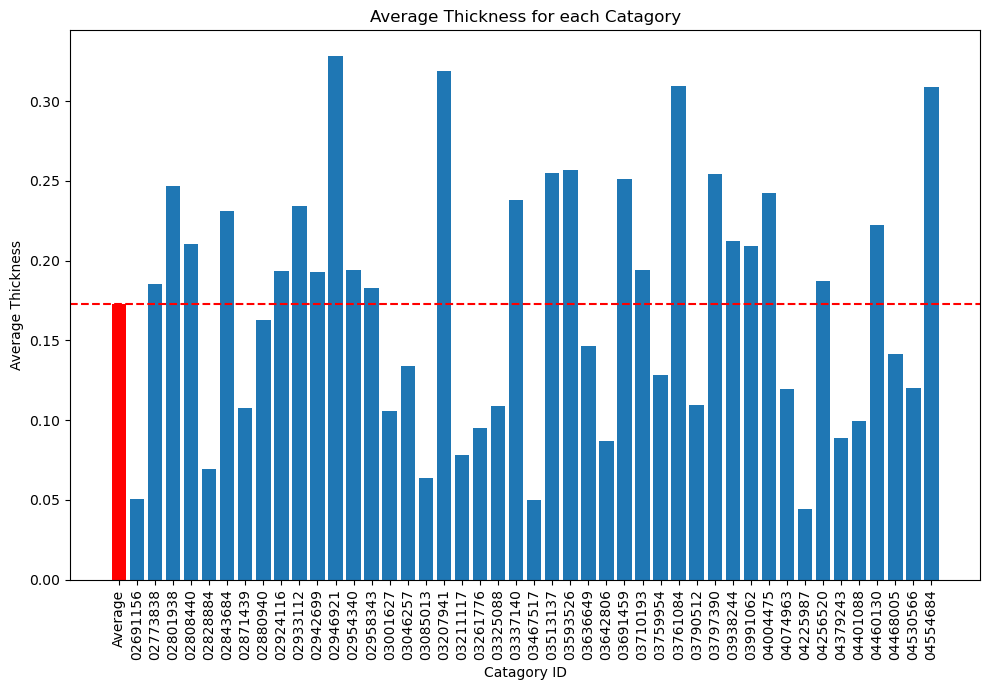

In [7]:
# Print average thickness for all catagories  
thick_avg = sum(avg_thick.values())/len(avg_thick) 
print("Average thickness for all catagories: ", thick_avg)
# Bar plot with ids from df labels are x vertical
# Make bassline bar red
fig, ax = plt.subplots(figsize=(10,7))
# make first bar red red light blue

clrs = ['r']+['#1f77b4']*(len(avg_thick))
ax.bar(["Average"]+ list(avg_thick.keys()), [thick_avg]+list(avg_thick.values()), color = clrs)#


ax.axhline(y=thick_avg, color='r', linestyle='--')


# make x axis labels readable
ax.set_xticklabels(["Average"]+ list(avg_thick.keys()), rotation = 90)
ax.set_xlabel('Catagory ID')
ax.set_ylabel('Average Thickness')
ax.set_title('Average Thickness for each Catagory')
fig.tight_layout()
fig.show()
# save as pdf
fig.savefig('figs/model/avg_thick.pdf', format='pdf')

Standard Deviation for all catagories:  0.1310443934032817


C:\Users\Jonathan Kane\AppData\Local\Temp\ipykernel_24580\3417945975.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Average"]+list(stds_list.keys()), rotation = 90)
C:\Users\Jonathan Kane\AppData\Local\Temp\ipykernel_24580\3417945975.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


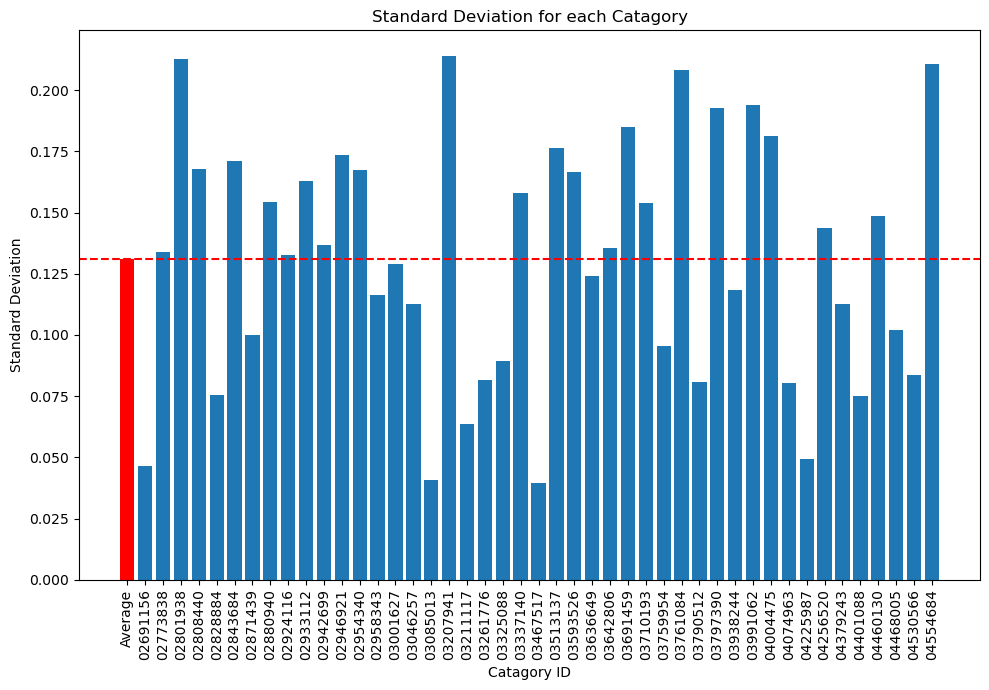

In [8]:
std_avg = sum(stds_list.values())/len(stds_list)
print("Standard Deviation for all catagories: ",std_avg)

# Bar plot with ids from df labels are x vertical  
fig, ax = plt.subplots(figsize=(10,7))
clrs = ['r']+['#1f77b4']*(len(stds_list))
ax.bar(["Average"]+list(stds_list.keys()), [std_avg]+list(stds_list.values()), color = clrs)
# make x axis labels readable
ax.axhline(y=std_avg, color='r', linestyle='--')

ax.set_xticklabels(["Average"]+list(stds_list.keys()), rotation = 90)
ax.set_xlabel('Catagory ID')
ax.set_ylabel('Standard Deviation')
ax.set_title('Standard Deviation for each Catagory')
fig.tight_layout()
fig.show()

# save as pdf
fig.savefig('figs/model//std_thick.pdf', format='pdf')


C:\Users\Jonathan Kane\AppData\Local\Temp\ipykernel_24580\1199201183.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(count_list.keys(), rotation = 90)


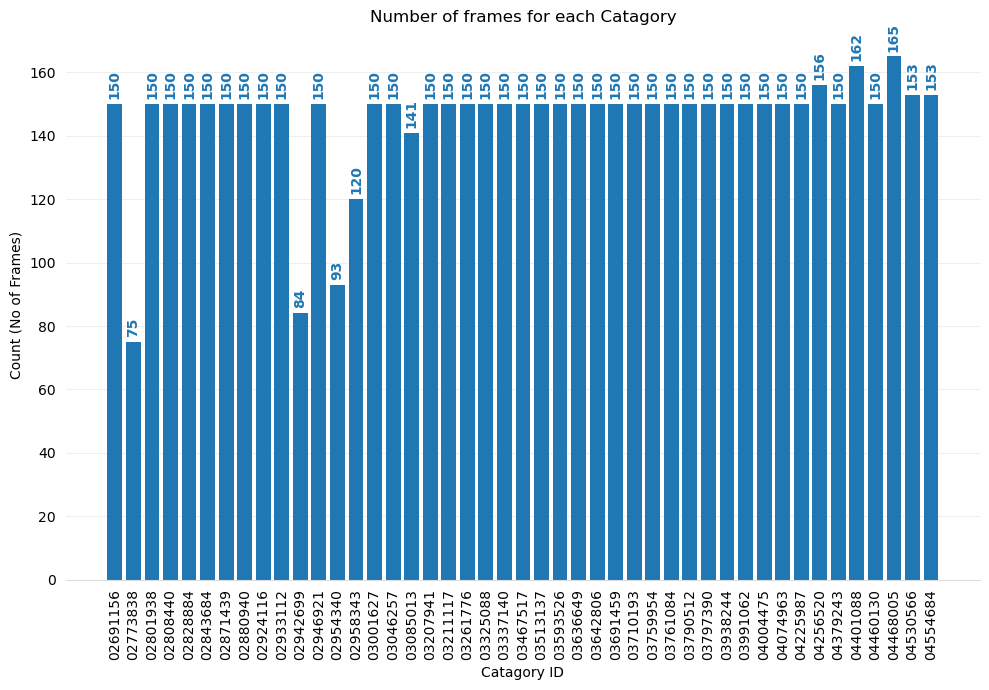

In [9]:
fig, ax = plt.subplots(figsize=(10,7))
bars  = ax.bar(count_list.keys(), count_list.values())
ax.set_xlabel('Catagory ID')
ax.set_ylabel('Count (No of Frames)')
ax.set_xticklabels(count_list.keys(), rotation = 90)
ax.set_title('Number of frames for each Catagory')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Second, remove the ticks as well.
ax.tick_params(bottom=False, left=False)

# Third, add a horizontal grid (but keep the vertical grid hidden).
# Color the lines a light gray as well.
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
# rotation=90
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 2.5,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold',
        rotation=90
  )

# Rotate the bar tex

fig.tight_layout()
plt.show()
# save the figure as pdf
fig.savefig('figs/model/catagory_count.pdf', format='pdf')


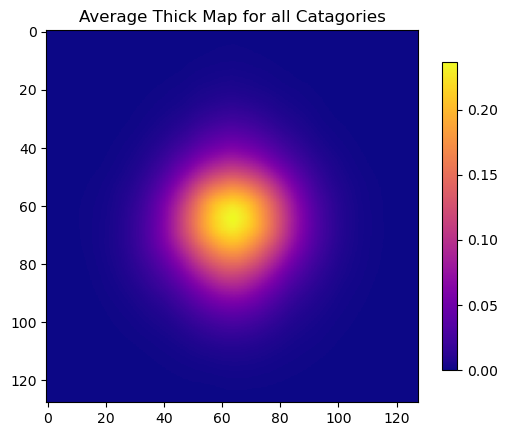

In [10]:
# calculate the mean depth map for all catagories
mean_thick_map = torch.mean(torch.stack(list(thick_list.values())), dim=0)

# Plot the mean depth map for all catagories
plt.figure(figsize=(6,5))
plt.imshow(mean_thick_map, cmap='plasma')
plt.title("Average Thick Map for all Catagories")
plt.colorbar(shrink=0.8)
plt.show()


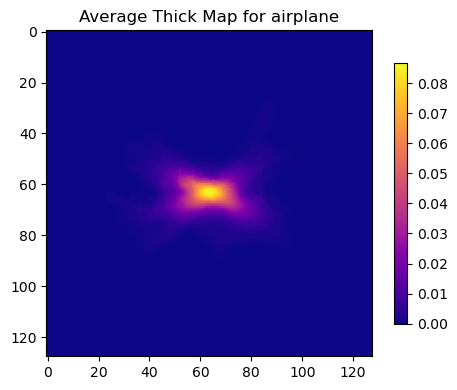

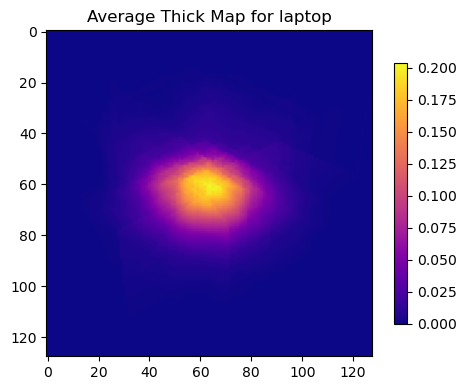

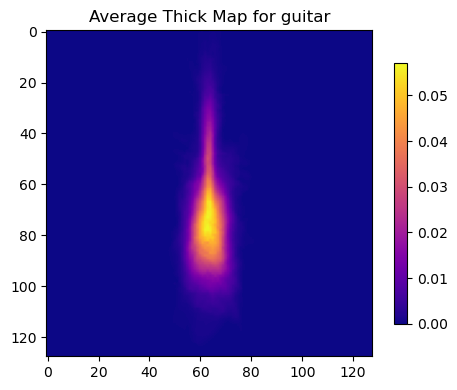

In [58]:
# Low bois
# save these 3 indvidual plot as pdfs 02691156 03642806 03467517
fig,ax = plt.subplots(figsize=(5,4))
pl = ax.imshow(thick_list['02691156'], cmap='plasma')
label = thickness_dataset.labels['02691156'].split(',')[0]
ax.set_title(f"Average Thick Map for {label}")
fig.colorbar(pl,shrink=0.8)
fig.tight_layout()
fig.savefig('figs/model/low_02691156_thick_avg.pdf', format='pdf')

fig,ax = plt.subplots(figsize=(5,4))
pl = ax.imshow(thick_list['03642806'], cmap='plasma')
label = thickness_dataset.labels['03642806'].split(',')[0]
ax.set_title(f"Average Thick Map for {label}")
fig.colorbar(pl,shrink=0.8)
fig.tight_layout()
fig.savefig('figs/model/low_03642806_thick_avg.pdf', format='pdf')

fig,ax = plt.subplots(figsize=(5,4))
pl = ax.imshow(thick_list['03467517'], cmap='plasma')
label = thickness_dataset.labels['03467517'].split(',')[0]
ax.set_title(f"Average Thick Map for {label}")
fig.colorbar(pl,shrink=0.8)
fig.tight_layout()
fig.savefig('figs/model/low_03467517_thick_avg.pdf', format='pdf')


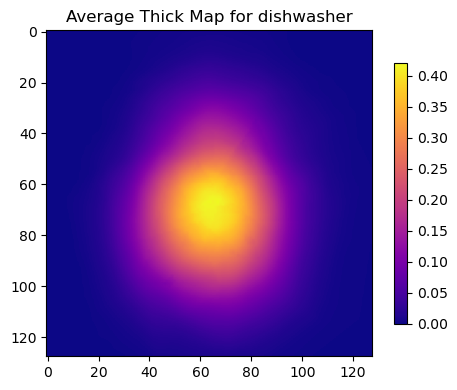

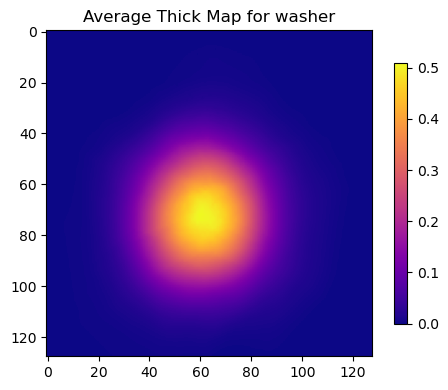

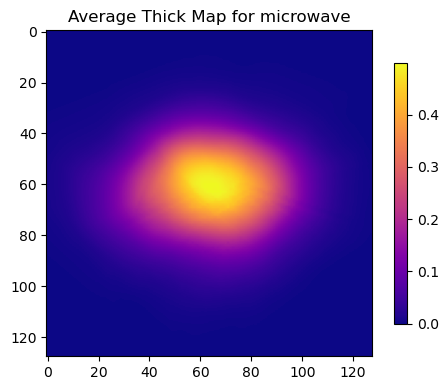

In [59]:
# High boys
# save these 3 indvidual plot as pdfs  03207941 and 04554684 and 03761084, Make the figs the same size
fig,ax = plt.subplots(figsize=(5,4))
pl = ax.imshow(thick_list['03207941'], cmap='plasma')
# remove everything after the comma on the title
label = thickness_dataset.labels['03207941'].split(',')[0]
ax.set_title(f"Average Thick Map for {label}")
fig.colorbar(pl,shrink=0.8)
fig.tight_layout()
fig.savefig('figs/model/high_03207941_thick_avg.pdf', format='pdf')

fig,ax = plt.subplots(figsize=(5,4))
pl = ax.imshow(thick_list['04554684'], cmap='plasma')
label = thickness_dataset.labels['04554684'].split(',')[0]
ax.set_title(f"Average Thick Map for {label}")
fig.colorbar(pl,shrink=0.8)
fig.tight_layout()
fig.savefig('figs/model/high_04554684_thick_avg.pdf', format='pdf')

fig,ax = plt.subplots(figsize=(5,4))
pl = ax.imshow(thick_list['03761084'], cmap='plasma')
label = thickness_dataset.labels['03761084'].split(',')[0]
ax.set_title(f"Average Thick Map for {label}")
fig.colorbar(pl,shrink=0.8)
fig.tight_layout()
fig.savefig('figs/model/high_03761084_thick_avg.pdf', format='pdf')
